In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pyfume.Clustering import Clusterer
from pyfume.EstimateAntecendentSet import AntecedentEstimator
from pyfume.EstimateConsequentParameters import ConsequentEstimator
from pyfume.SimpfulModelBuilder import SugenoFISBuilder
from pyfume.Tester import SugenoFISTester
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score
from numpy import clip, column_stack, argmax
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [16]:
# %% Load dataset and create train-test sets
Train = pd.read_csv('dataTrain.csv')
Test = pd.read_csv('dataTest.csv')

In [17]:
# Prepare the data
X_train = Train.drop('STATUS', axis=1).to_numpy()
y_train = Train['STATUS'].to_numpy()
X_test = Test.drop('STATUS', axis=1).to_numpy()
y_test = Test['STATUS'].to_numpy()

var_names = Train.columns[:-1].to_list()

In [18]:
# %% Function to train Takagi-Sugeno Model with clustering method selection
def train_takagi_sugeno(X_train, y_train, X_test, y_test, num_clusters=10, method='fcm'):
    # Cluster the input-output space
    cl = Clusterer(x_train=X_train, y_train=y_train, nr_clus=num_clusters)
    clust_centers, part_matrix, _ = cl.cluster(method=method)

    # Estimate membership functions parameters
    ae = AntecedentEstimator(X_train, part_matrix)
    antecedent_params = ae.determineMF()

    # Estimate consequent parameters
    ce = ConsequentEstimator(X_train, y_train, part_matrix)
    conseq_params = ce.suglms()

    # Build the Sugeno FIS model
    modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, var_names, save_simpful_code=False)
    model = modbuilder.get_model()

    # Get model predictions
    modtester = SugenoFISTester(model, X_test, var_names)
    y_pred_probs = np.clip(modtester.predict()[0], 0, 1)
    y_pred_probs = np.column_stack((1 - y_pred_probs, y_pred_probs))
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Compute classification metrics
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "Kappa": cohen_kappa_score(y_test, y_pred),
    }
    return metrics

# %% K-Fold Cross-Validation and Best Model Selection
methods = ['fcm', 'gk']  # Added Gustafson-Kessel method
num_clusters_list = [2, 3, 4, 5, 7]  # Hyperparameter tuning
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_model = None
best_score = 0

for method in methods:
    for num_clusters in num_clusters_list:
        fold_metrics = []
        for train_index, test_index in kf.split(X_train):
            X_tr, X_val = X_train[train_index], X_train[test_index]
            y_tr, y_val = y_train[train_index], y_train[test_index]
            try:
                metrics = train_takagi_sugeno(X_tr, y_tr, X_val, y_val, num_clusters=num_clusters, method=method)
                fold_metrics.append(metrics)
            except Exception as e:
                continue
        avg_accuracy = np.mean([m["Accuracy"] for m in fold_metrics])
        if avg_accuracy > best_score:
            best_score = avg_accuracy
            best_model = {
                "Method": method,
                "Num_Clusters": num_clusters,
                "Metrics": {key: np.mean([m[key] for m in fold_metrics]) for key in fold_metrics[0]}
            }

# %% Display Best Model Results
print(f"Best Model: Method = {best_model['Method']}, Clusters = {best_model['Num_Clusters']}")
for metric, value in best_model['Metrics'].items():
    print(f"{metric}: {value:.3f}")


 * Detected 2 rules / clusters
 * Detected Sugeno model type
 * Detected 2 rules / clusters
 * Detected Sugeno model type
 * Detected 2 rules / clusters
 * Detected Sugeno model type
 * Detected 2 rules / clusters
 * Detected Sugeno model type
 * Detected 2 rules / clusters
 * Detected Sugeno model type
 * Detected 3 rules / clusters
 * Detected Sugeno model type
 * Detected 3 rules / clusters
 * Detected Sugeno model type
 * Detected 3 rules / clusters
 * Detected Sugeno model type
 * Detected 3 rules / clusters
 * Detected Sugeno model type
 * Detected 3 rules / clusters
 * Detected Sugeno model type
 * Detected 4 rules / clusters
 * Detected Sugeno model type
 * Detected 4 rules / clusters
 * Detected Sugeno model type
 * Detected 4 rules / clusters
 * Detected Sugeno model type
 * Detected 4 rules / clusters
 * Detected Sugeno model type
 * Detected 4 rules / clusters
 * Detected Sugeno model type
 * Detected 5 rules / clusters
 * Detected Sugeno model type
 * Detected 5 rules / cl

In [19]:
# %% Train and Test the Best Model
def train_and_test_best_model(X_train, y_train, X_test, y_test, best_model):
    """
    Train and test a Takagi-Sugeno model with the best parameters and return predicted probabilities.
    """
    # Retrieve the best parameters
    method = best_model["Method"]
    num_clusters = best_model["Num_Clusters"]

    # Train the best model
    cl = Clusterer(x_train=X_train, y_train=y_train, nr_clus=num_clusters)
    clust_centers, part_matrix, _ = cl.cluster(method=method)

    # Estimate membership functions parameters
    ae = AntecedentEstimator(X_train, part_matrix)
    antecedent_params = ae.determineMF()

    # Estimate consequent parameters
    ce = ConsequentEstimator(X_train, y_train, part_matrix)
    conseq_params = ce.suglms()

    # Build the Sugeno FIS model
    modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, var_names, save_simpful_code=False)
    model = modbuilder.get_model()

    # Test the model
    modtester = SugenoFISTester(model, X_test, var_names)
    y_pred_probs = np.clip(modtester.predict()[0], 0, 1)  # Clip probabilities
    y_pred_probs = np.column_stack((1 - y_pred_probs, y_pred_probs))  # Binary probabilities

    return y_pred_probs


In [20]:
# %% Plot ROC Curve for the Best Model
def plot_roc_for_best_model(X_train, y_train, X_test, y_test, best_model):
    """
    Train the best model using best parameters and plot the ROC curve.
    """
    # Train and test the best model
    y_pred_probs = train_and_test_best_model(X_train, y_train, X_test, y_test, best_model)
    
    # Compute FPR, TPR, and AUC
    y_probs = y_pred_probs[:, 1]  # Assuming column 1 is the probability for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()


 * Detected 5 rules / clusters
 * Detected Sugeno model type


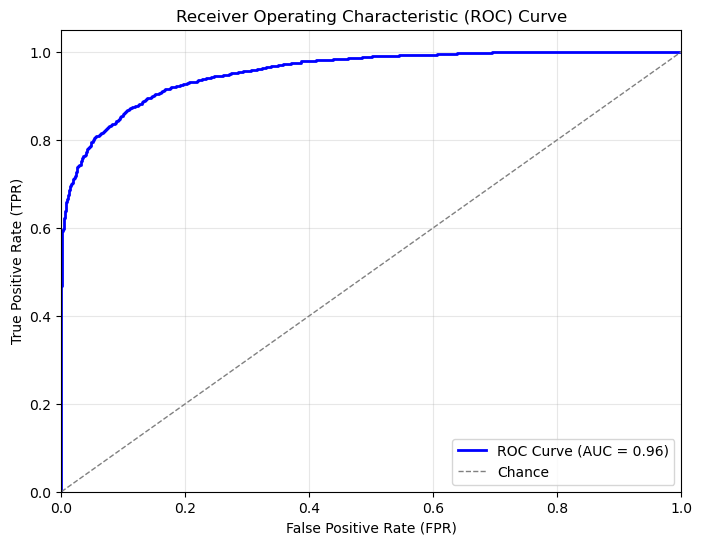

In [21]:
plot_roc_for_best_model(X_train, y_train, X_test, y_test, best_model)
